In [1]:
%config Completer.use_jedi = False

In [2]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
from IPython.display import HTML, Math

In [3]:
import sys; sys.getdefaultencoding()

'utf-8'

In [4]:
import torch
import torch.nn as nn
import torch_geometric
import networkx as nx
from goatools import obo_parser

#dealing with dataset
from torchvision import transforms
from torch.utils.data import Dataset
from torch_geometric.data import Data, DataLoader

from math import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

import os
import pickle
import time
import sys
import json

In [5]:
#Folders
DATASET=input("Which dataset are you using? TCGA or microarray")

Which dataset are you using? TCGA or microarrayTCGA


In [6]:
dir_data = "../data"

In [7]:
dir_files = "../files"

In [8]:
dir_log = "../log"

In [9]:
os.listdir(dir_log)

['GraphGONet_SELECTOP=top_SELECTRATIO=0.001']

In [10]:
#Selecting Model
dir_save = os.path.join(dir_log,"GraphGONet_SELECTOP=top_SELECTRATIO=0.001")
dir_save

'../log\\GraphGONet_SELECTOP=top_SELECTRATIO=0.001'

In [11]:
#Model Hyperparameters
with open(os.path.join(dir_save,'model_args.txt'), 'r') as fp:
    args = json.load(fp)
args.items()

dict_items([('dir_log', 'log'), ('dir_files', 'files'), ('dir_data', 'data'), ('file_extension', None), ('save', True), ('restore', False), ('processing', 'train_and_evaluate'), ('type_graph', 'truncated'), ('n_samples', None), ('n_inputs', 18427), ('n_nodes', 10636), ('n_nodes_annotated', 8288), ('dim_init', 1), ('n_prop1', 1), ('n_classes', 12), ('selection_op', 'top'), ('selection_ratio', 0.001), ('optimizer', 'adam'), ('lr', 0.001), ('es', True), ('patience', 5), ('delta', 0.001), ('batch_size', 64), ('n_epochs', 11), ('display_step', None), ('device', 'cpu'), ('class_weight', True), ('checkpoint', 'model.pt'), ('dir_save', 'log\\GraphGONet_SELECTOP=top_SELECTRATIO=0.001'), ('learning_time', 4391.471603870392)])

In [12]:
#For the architecture
TYPE_GRAPH = args["type_graph"]
SHAPE_FEATURES = args["n_inputs"]
DIM_INITIAL = args["dim_init"]
DIM_FINAL = args["n_prop1"] 
N_GO_ANNOT = args["n_nodes_annotated"] 
N_GO = args["n_nodes"] 
N_OUTPUT = args["n_classes"]

#For the inference process
SELECT_OP = args["selection_op"]
SELECT_RATIO = args["selection_ratio"]

N_EPOCHS = args["n_epochs"]
DISPLAY_STEP = args["display_step"]

In [13]:
#Load Dataset and Clean
start = time.time()

In [14]:
#Gene Expression
#Selection of the probes connected to a GO-term in list
%time
mask_features = np.load(os.path.join(dir_files,"genes_annotated.npz"))["mask"]

Wall time: 0 ns


In [15]:
#Dataset container
class GeneExpressionDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, file_name,mask_features=None,transform=None,n_classes=1,class_weights=False,n_samples=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        loader =  np.load(file_name)
        self.X = loader['x'].astype('float32')
        if n_classes <2 :
            self.y = loader['y'].astype('float32')
        else:
            self.y = loader['y']
        self.transform = transform
        
        if self.y.dtype =='<U4':
            le = preprocessing.LabelEncoder()
            le.fit(self.y)
            self.y = le.transform(self.y)
            self.target_names = list(le.classes_)
        else:
            self.target_names = ["noncancer","cancer"]
            
        if mask_features is not None:
            self.X = self.X[:,mask_features]
        if n_samples:
            sss = StratifiedShuffleSplit(n_splits=1,train_size=n_samples,test_size=self.X.shape[0]-n_samples,random_state=42) #keeping the proportion of the original classes
            for train_index, test_index in sss.split(self.X , self.y):
                self.X, self.y = self.X[train_index,:], self.y[train_index]

        if class_weights:
            self.class_weight = torch.tensor(class_weight.compute_class_weight('balanced',
                                                 np.unique(self.y),
                                                 self.y).astype('float32'))

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = {'data': self.X[idx,], 'labels': self.y[idx]}
        
        if self.transform:
            sample['data'] = self.transform(sample['data'])
            sample['labels'] = torch.tensor(sample['labels'])

        return sample["data"],sample["labels"]

In [16]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, data):
        return torch.from_numpy(data)

In [17]:
%%time
testset = GeneExpressionDataset(file_name=os.path.join(dir_data,"X_test.npz"),
                                 transform=transforms.Compose([ToTensor()]),n_classes=N_OUTPUT, mask_features = mask_features)

Wall time: 4.42 s


In [18]:
#Load the associated connection matrix
%time
matrix_connection = pd.read_csv(os.path.join(dir_files,"matrix_connection_{}.csv".format(TYPE_GRAPH)),index_col=0,encoding='utf-8')
matrix_connection.head()

Wall time: 0 ns


,GO:0000002,GO:0000003,GO:0000012,GO:0000018,GO:0000019,GO:0000027,GO:0000028,GO:0000038,GO:0000045,GO:0000052,...,GO:2001207,GO:2001215,GO:2001228,GO:2001248,GO:2001262,GO:2001263,GO:2001270,GO:2001293,GO:2001302,GO:2001304
ENSG00000000003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000000005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000000419,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000000457,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000000938,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
#Load the truncated graph
matrix_connection.shape

(18427, 8288)

In [20]:
matrix_connection[matrix_connection==1].sum().sum()

115340.0

In [21]:
list_go = matrix_connection.columns

In [22]:
graph = nx.read_gpickle(os.path.join(dir_files,"gobp-{}-converted".format(TYPE_GRAPH)))

In [23]:
print(nx.info(graph))

Name: go
Type: MultiDiGraph
Number of nodes: 10636
Number of edges: 23824
Average in degree:   2.2399
Average out degree:   2.2399


In [24]:
with open(os.path.join(dir_files,'map_int_go_{}.txt'.format(TYPE_GRAPH)), 'r') as fp:
    map_int_go = json.load(fp)
map_int_go.items()

dict_items([('0', 'GO:0000002'), ('1', 'GO:0000003'), ('2', 'GO:0000012'), ('3', 'GO:0000018'), ('4', 'GO:0000019'), ('5', 'GO:0000027'), ('6', 'GO:0000028'), ('7', 'GO:0000038'), ('8', 'GO:0000045'), ('9', 'GO:0000052'), ('10', 'GO:0000054'), ('11', 'GO:0000056'), ('12', 'GO:0000070'), ('13', 'GO:0000076'), ('14', 'GO:0000077'), ('15', 'GO:0000079'), ('16', 'GO:0000082'), ('17', 'GO:0000083'), ('18', 'GO:0000086'), ('19', 'GO:0000096'), ('20', 'GO:0000097'), ('21', 'GO:0000098'), ('22', 'GO:0000117'), ('23', 'GO:0000122'), ('24', 'GO:0000154'), ('25', 'GO:0000165'), ('26', 'GO:0000183'), ('27', 'GO:0000184'), ('28', 'GO:0000186'), ('29', 'GO:0000187'), ('30', 'GO:0000188'), ('31', 'GO:0000209'), ('32', 'GO:0000212'), ('33', 'GO:0000226'), ('34', 'GO:0000245'), ('35', 'GO:0000266'), ('36', 'GO:0000272'), ('37', 'GO:0000278'), ('38', 'GO:0000281'), ('39', 'GO:0000288'), ('40', 'GO:0000289'), ('41', 'GO:0000291'), ('42', 'GO:0000296'), ('43', 'GO:0000302'), ('44', 'GO:0000303'), ('45', '

In [25]:
map_int_go={int(idx):go for idx,go in map_int_go.items()}
map_int_go

{0: 'GO:0000002',
 1: 'GO:0000003',
 2: 'GO:0000012',
 3: 'GO:0000018',
 4: 'GO:0000019',
 5: 'GO:0000027',
 6: 'GO:0000028',
 7: 'GO:0000038',
 8: 'GO:0000045',
 9: 'GO:0000052',
 10: 'GO:0000054',
 11: 'GO:0000056',
 12: 'GO:0000070',
 13: 'GO:0000076',
 14: 'GO:0000077',
 15: 'GO:0000079',
 16: 'GO:0000082',
 17: 'GO:0000083',
 18: 'GO:0000086',
 19: 'GO:0000096',
 20: 'GO:0000097',
 21: 'GO:0000098',
 22: 'GO:0000117',
 23: 'GO:0000122',
 24: 'GO:0000154',
 25: 'GO:0000165',
 26: 'GO:0000183',
 27: 'GO:0000184',
 28: 'GO:0000186',
 29: 'GO:0000187',
 30: 'GO:0000188',
 31: 'GO:0000209',
 32: 'GO:0000212',
 33: 'GO:0000226',
 34: 'GO:0000245',
 35: 'GO:0000266',
 36: 'GO:0000272',
 37: 'GO:0000278',
 38: 'GO:0000281',
 39: 'GO:0000288',
 40: 'GO:0000289',
 41: 'GO:0000291',
 42: 'GO:0000296',
 43: 'GO:0000302',
 44: 'GO:0000303',
 45: 'GO:0000305',
 46: 'GO:0000375',
 47: 'GO:0000380',
 48: 'GO:0000387',
 49: 'GO:0000398',
 50: 'GO:0000414',
 51: 'GO:0000416',
 52: 'GO:0000422',
 53

In [26]:
map_go_int={go:idx for idx,go in map_int_go.items()}
map_go_int

{'GO:0000002': 0,
 'GO:0000003': 1,
 'GO:0000012': 2,
 'GO:0000018': 3,
 'GO:0000019': 4,
 'GO:0000027': 5,
 'GO:0000028': 6,
 'GO:0000038': 7,
 'GO:0000045': 8,
 'GO:0000052': 9,
 'GO:0000054': 10,
 'GO:0000056': 11,
 'GO:0000070': 12,
 'GO:0000076': 13,
 'GO:0000077': 14,
 'GO:0000079': 15,
 'GO:0000082': 16,
 'GO:0000083': 17,
 'GO:0000086': 18,
 'GO:0000096': 19,
 'GO:0000097': 20,
 'GO:0000098': 21,
 'GO:0000117': 22,
 'GO:0000122': 23,
 'GO:0000154': 24,
 'GO:0000165': 25,
 'GO:0000183': 26,
 'GO:0000184': 27,
 'GO:0000186': 28,
 'GO:0000187': 29,
 'GO:0000188': 30,
 'GO:0000209': 31,
 'GO:0000212': 32,
 'GO:0000226': 33,
 'GO:0000245': 34,
 'GO:0000266': 35,
 'GO:0000272': 36,
 'GO:0000278': 37,
 'GO:0000281': 38,
 'GO:0000288': 39,
 'GO:0000289': 40,
 'GO:0000291': 41,
 'GO:0000296': 42,
 'GO:0000302': 43,
 'GO:0000303': 44,
 'GO:0000305': 45,
 'GO:0000375': 46,
 'GO:0000380': 47,
 'GO:0000387': 48,
 'GO:0000398': 49,
 'GO:0000414': 50,
 'GO:0000416': 51,
 'GO:0000422': 52,
 'G

In [27]:
leaves = [map_int_go[node] for node in graph.nodes if (graph.in_degree(node) == 0)]

In [28]:
leaves_idx = [node for node in graph.nodes if (graph.in_degree(node) == 0)]
leaves_idx

[5,
 6,
 7,
 13,
 15,
 17,
 22,
 28,
 29,
 30,
 6576,
 6577,
 42,
 47,
 48,
 6578,
 6579,
 51,
 6580,
 6581,
 6582,
 54,
 6583,
 56,
 57,
 58,
 61,
 6584,
 63,
 6585,
 80,
 6586,
 84,
 6587,
 6588,
 87,
 6589,
 6590,
 6591,
 6592,
 88,
 6593,
 101,
 104,
 107,
 112,
 6594,
 128,
 6595,
 160,
 161,
 6596,
 168,
 6597,
 170,
 6598,
 6599,
 180,
 181,
 190,
 6600,
 202,
 204,
 6601,
 211,
 212,
 213,
 214,
 6602,
 220,
 221,
 229,
 230,
 233,
 236,
 6603,
 6604,
 241,
 6605,
 6606,
 247,
 253,
 254,
 255,
 259,
 267,
 268,
 270,
 272,
 274,
 275,
 276,
 277,
 278,
 279,
 280,
 6607,
 282,
 290,
 6608,
 6609,
 303,
 304,
 305,
 6610,
 6611,
 317,
 320,
 6612,
 6613,
 323,
 329,
 6614,
 6615,
 6616,
 6617,
 343,
 6618,
 6619,
 359,
 6620,
 6621,
 6622,
 366,
 372,
 6623,
 377,
 379,
 382,
 6624,
 6625,
 6626,
 383,
 6627,
 6628,
 384,
 385,
 6629,
 6630,
 6631,
 6632,
 391,
 393,
 394,
 399,
 400,
 6633,
 411,
 421,
 422,
 6634,
 424,
 425,
 6635,
 6636,
 437,
 6637,
 6638,
 6639,
 446,
 44

In [29]:
%time
df_go_level=pd.read_csv(os.path.join(dir_files,"go_to_level_{}.csv".format(TYPE_GRAPH)),index_col=0,encoding='utf-8')

Wall time: 0 ns


In [30]:
df_go_level.head()

,root,d+,d-
GO:0000002,6,1,1
GO:0000003,1,1,4
GO:0000012,8,1,3
GO:0000018,8,2,8
GO:0000019,9,2,2


In [31]:
go_obo = os.path.join(dir_files,'go-basic.obo')
go = obo_parser.GODag(go_obo)

../files\go-basic.obo: fmt(1.2) rel(2020-06-01) 47,233 Terms


In [32]:
#Convert the graph to a Graph Tensor
def from_networkx(G,dim_inital_node_embedding,label,random=False):
    r"""Converts a :obj:`networkx.Graph` or :obj:`networkx.DiGraph` to a
    :class:`torch_geometric.data.Data` instance.

    Args:
        G (networkx.Graph or networkx.DiGraph): A networkx graph.
        label (list): Label of patient's outcome. (binary(scalar): 0/1)
        dim_inital_node_embedding (int): Here 1, initialized to 0 and will be updated latter after applying the first module.
        random (bool, optional): generate random embeddings for nodes without GO annotations. The samples share the same initial graph.
    """

    G = G.to_directed() if not nx.is_directed(G) else G
    edge_index = torch.tensor(list(G.edges(data=False))).t().contiguous()

    data = {}

    data['edge_index'] = edge_index.view(2, -1)
    data = torch_geometric.data.Data.from_dict(data)
    data.num_nodes = G.number_of_nodes()
    if random:
        data.x = torch.cat((torch.zeros(len(list_go),dim_inital_node_embedding),torch.randn(data.num_nodes-len(list_go), dim_inital_node_embedding)),0)
    else: 
        data.x = torch.zeros(data.num_nodes, dim_inital_node_embedding)
    #initialize the nodes without direct GO annotations to a random value in a gaussian
    
    #all the parameters of the class Data are optional. Here, the parameters edge_attr,pos,normal,face are set to None.

    return data

In [33]:
graph = from_networkx(graph,dim_inital_node_embedding=DIM_INITIAL,label=N_OUTPUT)

In [34]:
graph.contains_isolated_nodes()

False

In [35]:
graph.contains_self_loops()

False

In [36]:
graph.is_directed()

True

In [37]:
#Create a graph for each sample
n_samples = testset.X.shape[0]
data_list = [graph.clone() for i in np.arange(n_samples)]

In [38]:
end = time.time()
elapsed=end - start
print("Total time: {}h {}min {}sec".format(time.gmtime(elapsed).tm_hour,
time.gmtime(elapsed).tm_min,
time.gmtime(elapsed).tm_sec))

Total time: 0h 0min 51sec


In [39]:
#Define the architecture
from typing import Union, Tuple, Callable, Optional
from torch_geometric.typing import OptPairTensor, Adj, Size, OptTensor
from torch import Tensor
from torch.nn import Linear, Parameter
import torch.nn.functional as F
from torch_sparse import SparseTensor, matmul
from torch_scatter import scatter,scatter_add
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.pool.topk_pool import topk, filter_adj

In [40]:
class DAGProp(torch.nn.Module):
    r"""
    Args:
        in_channels (int or tuple): Size of each input sample. A tuple
            corresponds to the sizes of source and target dimensionalities.
        out_channels (int): Size of each output sample.
        root_weight (bool, optional): If set to :obj:`False`, the layer will
            not add transformed root node features to the output.
            (default: :obj:`True`)
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
        nonlinearity (torch.nn.functional, optional): The nonlinearity to use.
            (default: :obj:`torch.tanh`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.
    """
    def __init__(self, in_channels: Union[int, Tuple[int, int]],
                 out_channels: int, root_weight: bool = True,
                 bias: bool = True, nonlinearity: Callable = torch.tanh, aggr: str = "mean",**kwargs):
        super(DAGProp, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.root_weight = root_weight
        self.nonlinearity = nonlinearity
        self.aggr = aggr

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)

        self.lin_l = Linear(in_channels[0], out_channels, bias=bias)
        if self.root_weight:
            self.lin_r = Linear(in_channels[1], out_channels, bias=False)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_l.reset_parameters()
        if self.root_weight:
            self.lin_r.reset_parameters()

    def forward(self, x: Tensor, edge_index: Adj, batch: OptTensor = None , 
                size: Size = None) -> Tensor:
        num_nodes = scatter_add(batch.new_ones(x.size(0),dtype=torch.int16), batch, dim=0)
        batch_size, max_num_nodes = num_nodes.size(0), num_nodes.max().item()
        num_edges_ref = edge_index.shape[1] // batch_size
        
        out = x.new_zeros(x.size())
        visited = x.new_zeros(size=(x.size(0),),dtype=torch.int16) 

        #1. Start propagation from the leaves

        leaves = torch.where(scatter(src=edge_index.new_ones(edge_index[1,:].size(),dtype=torch.int8),
                            index=edge_index[1,:], reduce="sum")==0)[0]
        out[leaves] = self.nonlinearity(x[leaves])
        visited[leaves]=1
        
        #2. Compute self-nodes processing (case: N_{x_{v}}!=0)

        if self.root_weight:
            temp = x[leaves]
            x[leaves] = 0
            mask = x.nonzero(as_tuple=True)[0]
            x[leaves] = temp
            out[mask] = self.lin_r(x[mask]) 
        
        #3. Update the embedding of the other nodes 
        
        previous_visits = leaves[leaves < max_num_nodes]
        adj_mat_cropped = edge_index[:,:num_edges_ref]
        while torch.sum(visited)!=visited.shape[0]: 
            mask=(adj_mat_cropped[0,:][..., None] == previous_visits).any(-1)
            fathers = torch.unique(adj_mat_cropped[1,mask])
            del mask
            mask=(adj_mat_cropped[1,:][..., None]== fathers).any(-1)
            mask1=scatter(src=visited[adj_mat_cropped[0,mask]], index=adj_mat_cropped[1,mask], reduce="sum")
            mask1=mask1[fathers]
            mask2=scatter(src=visited.new_ones(size=visited[adj_mat_cropped[0,mask]].size(),dtype=torch.int16), index=adj_mat_cropped[1,mask], reduce="sum")
            mask2=mask2[fathers]
            ref_next_visits = fathers[mask1==mask2]
            del mask
            mask = (adj_mat_cropped[1,:][..., None] == ref_next_visits).any(-1) 
            adj_mat = [adj_mat_cropped[:,mask] + i*max_num_nodes for i in range(batch_size)]
            adj_mat = torch.cat(adj_mat, dim=1)
            next_visits = [ref_next_visits + i*max_num_nodes for i in range(batch_size)]
            next_visits = torch.cat(next_visits, dim=0)
            mask = adj_mat[0,:]
            children = out[mask].view(-1)
            out[next_visits] += self.lin_l(scatter(src=children,index=adj_mat[1,:],reduce=self.aggr)[next_visits][:,None])
            out[next_visits] = self.nonlinearity(out[next_visits])
            previous_visits = ref_next_visits
            visited[next_visits]=1

        return out

    def __repr__(self):
        return '{}({}, {}, aggr={}, nonlinearity={})'.format(self.__class__.__name__, self.in_channels,
                                   self.out_channels,self.aggr,self.nonlinearity.__name__)

In [41]:
class TopSelection(torch.nn.Module):
    def __init__(self, in_channels: int, ratio: Union[float, int] = 0.5, **kwargs):
        super(TopSelection, self).__init__()

        self.in_channels = in_channels
        self.ratio = ratio

    def forward(self, x, edge_index, edge_attr=None, batch=None):
        if batch is None:
            batch = edge_index.new_zeros(x.size(0))
        
        perm = topk(torch.abs(x).view(-1), self.ratio, batch)
        num_nodes = x.size(0)
        x = x[perm]
        batch = batch[perm]
        edge_index, edge_attr = filter_adj(edge_index, edge_attr, perm,
                                           num_nodes=num_nodes)
        return x, edge_index, edge_attr, batch, perm, x

    def __repr__(self):
        return '{}({}, ratio={})'.format(
            self.__class__.__name__, 
            self.in_channels,
            self.ratio)

In [42]:
class RandomSelection(torch.nn.Module):
    def __init__(self, in_channels: int, ratio: Union[float, int] = 0.5, **kwargs):
        super(RandomSelection, self).__init__()

        self.in_channels = in_channels
        self.ratio = ratio

    def forward(self, x, edge_index, edge_attr=None, batch=None, attn=None):
        if batch is None:
            batch = edge_index.new_zeros(x.size(0))
        max_num_nodes = scatter_add(batch.new_ones(x.size(0),dtype=torch.int16), batch, dim=0).max().item()  
        perm = [torch.sort(torch.randperm(max_num_nodes,dtype=torch.long, device=x.device)[:ceil(max_num_nodes*self.ratio)]+k*max_num_nodes,descending=False)[0] for k in torch.unique(batch)]
        perm = torch.cat(perm, dim=0)
        num_nodes = x.size(0)
        x = x[perm]
        batch = batch[perm]
        edge_index, edge_attr = filter_adj(edge_index, edge_attr, perm, num_nodes = num_nodes)

        return x, edge_index, edge_attr, batch, perm, x

    def __repr__(self):
        return '{}({}, ratio={})'.format(
            self.__class__.__name__, 
            self.in_channels,
            self.ratio)

In [43]:
def concatenate(x: Tensor, batch: Tensor, size: Optional[int] = None) -> Tensor:
    batch_size = int(batch.max().item() + 1) if size is None else size
    return x.view(batch_size,-1)

def concatenate_and_mask(x: Tensor, batch: Tensor, idx_nodes_kept : Tensor, num_nodes : Tensor) -> Tensor:
    num_nodes_kept = scatter_add(batch.new_ones(x.size(0),dtype=torch.int16), batch, dim=0)
    batch_size, max_num_nodes = num_nodes_kept.size(0), num_nodes.max().item()
    output = x.new_zeros((batch_size,max_num_nodes)) 
    for i in torch.arange(batch_size):
        mask = idx_nodes_kept[i*num_nodes_kept[i]:(i+1)*num_nodes_kept[i]] - i*num_nodes[i]
        output[i,mask]=x[i*num_nodes_kept[i]:(i+1)*num_nodes_kept[i]].view(-1)
    return output

class Mask(torch.nn.Module):
    def __init__(self, in_channels, method, n_nodes, **kwargs):
        super(Mask, self).__init__()
        self.method = method
        self.in_channels = in_channels
        if self.method.__name__ == "global_mean_pool": 
            self.out_neurons=1
        else:
            self.out_neurons=n_nodes

    def forward(self, *args):
        return self.method(*args)
        
    def __repr__(self):
        return '{}({}, {}, method={})'.format(
            self.__class__.__name__,
            self.out_neurons,
            self.in_channels,
            self.method.__name__)

In [44]:
class Net(torch.nn.Module):
    def __init__(self,n_genes,n_nodes,n_nodes_annot,n_nodes_emb,n_prop1,n_classes,adj_mat_fc1,
                 propagation="DAGProp",selection=None,ratio=1.0,
                 mask="concatenate_and_mask"):
        super(Net, self).__init__()
        self.n_genes = n_genes
        self.n_nodes = n_nodes
        self.n_nodes_annot = n_nodes_annot
        self.n_nodes_emb = n_nodes_emb
        self.n_prop1 = n_prop1
        self.n_classes = n_classes
        adj_mat_fc1 = torch.tensor(adj_mat_fc1, dtype=torch.float).t()
        self.adj_mat_fc1 = Parameter(adj_mat_fc1, requires_grad=False)
        self.fc1 = Linear(in_features=n_genes,out_features=n_nodes_annot)
        with torch.no_grad():
            self.fc1.weight.mul_(self.adj_mat_fc1)
        self.propagation = eval(propagation)(in_channels=n_nodes_emb, out_channels=n_prop1,aggr = "mean")
        if selection:
            self.ratio = ratio
            if selection=="random":
                self.selection = RandomSelection(in_channels=n_prop1,ratio=ratio)
            elif selection=="top":
                self.selection = TopSelection(in_channels=n_prop1,ratio=ratio)
        else:
            mask="concatenate"
        self.mask = Mask(method=globals()[mask],in_channels=n_prop1,n_nodes=n_nodes) 
        self.fc2 = Linear(in_features=n_nodes,out_features=n_classes)

    def forward(self,transcriptomic_data,graph_data):
        x, edge_index, batch = graph_data.x, graph_data.edge_index, graph_data.batch
        initial_embedding = self.fc1(transcriptomic_data)
        for k in np.arange(graph_data.num_graphs): 
            x[self.n_nodes*k:self.n_nodes*k+self.n_nodes_annot]=initial_embedding[k].unsqueeze_(1)
        x = self.propagation(x, edge_index,batch)
        
        num_nodes = scatter_add(batch.new_ones(x.size(0),dtype=torch.int16), batch, dim=0)
        
        if self.selection: 
            x, edge_index, _, batch,idx_nodes_kept,_ = self.selection(x, edge_index, None, batch)
        
        if self.mask.method.__name__ == "concatenate_and_mask":
            x = self.mask(x,batch,idx_nodes_kept,num_nodes)
        else:
            x = self.mask(x,batch)
            
        x = self.fc2(x)
        
        if self.n_classes >=2:
            return x
        else:
            return x.view(-1)

In [45]:
def model_forward(batchGE, batchGraph):
    batchGraph=batchGraph.to(device)
    out = model(transcriptomic_data=batchGE, graph_data=batchGraph)
    return out

In [46]:
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [47]:
def get_pool(name):
    def hook(model, input, output):
        activation[name] = {}
        activation[name]["output"] = output[0].detach()
        activation[name]["edge_index"] = output[1].detach()
        activation[name]["idx_top_nodes"] = output[4].detach()
    return hook

In [48]:
def get_accuracy(y_true, y_pred):
    return int(np.sum(np.equal(y_true,y_pred))) / y_true.shape[0]

In [49]:
#Load the saved model
%time
device = torch.device('cpu')
model = Net(n_genes=SHAPE_FEATURES,n_nodes=N_GO,n_nodes_annot=N_GO_ANNOT,n_nodes_emb=DIM_INITIAL,n_classes=N_OUTPUT,n_prop1=DIM_FINAL,adj_mat_fc1=matrix_connection.values,
            selection=SELECT_OP,ratio=SELECT_RATIO)
model.load_state_dict(torch.load(os.path.join(dir_save,args["checkpoint"]), map_location=device))
model.eval()

Wall time: 0 ns


Net(
  (fc1): Linear(in_features=18427, out_features=8288, bias=True)
  (propagation): DAGProp(1, 1, aggr=mean, nonlinearity=tanh)
  (selection): TopSelection(1, ratio=0.001)
  (mask): Mask(10636, 1, method=concatenate_and_mask)
  (fc2): Linear(in_features=10636, out_features=12, bias=True)
)

In [50]:
BATCH_SIZE = testset.y.shape[0] #args["batch_size"]
BATCH_SIZE 

1293

In [51]:
%time
testloaderGraph = DataLoader(data_list, batch_size=BATCH_SIZE,shuffle=False)

Wall time: 0 ns


In [52]:
%time
testloaderGE = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=0)

Wall time: 0 ns


In [53]:
from captum.attr import LayerGradientXActivation

In [54]:
layer_ga = LayerGradientXActivation(model_forward, model.mask)#model

In [55]:
batchGE,labels=next(iter(testloaderGE))
batchGraph=next(iter(testloaderGraph))
activation = {}
model.eval()
with torch.no_grad():
    model.mask.register_forward_hook(get_activation('mask'))
    output = model(transcriptomic_data=batchGE,graph_data=batchGraph)
    if N_OUTPUT >=2:
        prob = torch.nn.Softmax(dim=1)(output)
        pred = prob.argmax(axis=1)
    else:
        prob = torch.sigmoid(output)
        pred = (output>0.5)
    print(pred.float())
    print(labels)

tensor([2., 1., 7.,  ..., 9., 2., 5.])
tensor([0, 6, 7,  ..., 9, 2, 2], dtype=torch.int32)


In [56]:
%time
batchGE=batchGE.requires_grad_(True).to(device)
if DATASET=="TCGA":
    attribution = layer_ga.attribute(inputs=batchGE,target=pred,additional_forward_args=(batchGraph,))
else:
    attribution = layer_ga.attribute(inputs=batchGE,additional_forward_args=(batchGraph,))

Wall time: 0 ns


In [57]:
pred.shape

torch.Size([1293])

In [58]:
get_accuracy(labels.numpy(), pred.numpy())

0.642691415313225

In [59]:
activation_map_mask = activation['mask'].view([BATCH_SIZE,-1])
activation_map_mask.shape

torch.Size([1293, 10636])

In [60]:
if DATASET=="TCGA":
    map_idx_class = {idx : label for idx,label in enumerate(testset.target_names)}
else:
    map_idx_class = {idx : label for idx,label in enumerate(testset.target_names)}

In [61]:
#Study the frequency and the sign of neurons for a given class
first_index = np.array([[id_go]*2 for id_go in map_int_go.values()]).reshape(-1)
second_index = ["+","-"]*N_GO

In [62]:
df_map_sign = pd.DataFrame(np.zeros((testset.X.shape[0],first_index.shape[0]),dtype=np.int8),index=np.arange(testset.X.shape[0]),columns=[first_index, second_index])
df_map_sign.head()

GO:0000002    GO:0000003    GO:0000012    GO:0000018    GO:0000019     ...  \
           +  -          +  -          +  -          +  -          +  -  ...   
0          0  0          0  0          0  0          0  0          0  0  ...   
1          0  0          0  0          0  0          0  0          0  0  ...   
2          0  0          0  0          0  0          0  0          0  0  ...   
3          0  0          0  0          0  0          0  0          0  0  ...   
4          0  0          0  0          0  0          0  0          0  0  ...   

  GO:2001197    GO:2001233    GO:2001267    GO:2001279    GO:2001300     
           +  -          +  -          +  -          +  -          +  -  
0          0  0          0  0          0  0          0  0          0  0  
1          0  0          0  0          0  0          0  0          0  0  
2          0  0          0  0          0  0          0  0          0  0  
3          0  0          0  0          0  0          0  0          0  0  
4          0  0          0  0          0  0          0  0          0  0  

[5 rows x 21272 columns]

In [63]:
%time
for n in np.arange(testset.X.shape[0]):
    print("Processing sample {}".format(n))
    for idx_go,id_go in map_int_go.items():
        sign_go = np.sign(activation_map_mask[n,idx_go])
        if sign_go==-1:
            df_map_sign.loc[n,(id_go,"-")]= 1
        elif sign_go==1:
            df_map_sign.loc[n,(id_go,"+")]= 1

Wall time: 0 ns
Processing sample 0
Processing sample 1
Processing sample 2
Processing sample 3
Processing sample 4
Processing sample 5
Processing sample 6
Processing sample 7
Processing sample 8
Processing sample 9
Processing sample 10
Processing sample 11
Processing sample 12
Processing sample 13
Processing sample 14
Processing sample 15
Processing sample 16
Processing sample 17
Processing sample 18
Processing sample 19
Processing sample 20
Processing sample 21
Processing sample 22
Processing sample 23
Processing sample 24
Processing sample 25
Processing sample 26
Processing sample 27
Processing sample 28
Processing sample 29
Processing sample 30
Processing sample 31
Processing sample 32
Processing sample 33
Processing sample 34
Processing sample 35
Processing sample 36
Processing sample 37
Processing sample 38
Processing sample 39
Processing sample 40
Processing sample 41
Processing sample 42
Processing sample 43
Processing sample 44
Processing sample 45
Processing sample 46
Process

Processing sample 377
Processing sample 378
Processing sample 379
Processing sample 380
Processing sample 381
Processing sample 382
Processing sample 383
Processing sample 384
Processing sample 385
Processing sample 386
Processing sample 387
Processing sample 388
Processing sample 389
Processing sample 390
Processing sample 391
Processing sample 392
Processing sample 393
Processing sample 394
Processing sample 395
Processing sample 396
Processing sample 397
Processing sample 398
Processing sample 399
Processing sample 400
Processing sample 401
Processing sample 402
Processing sample 403
Processing sample 404
Processing sample 405
Processing sample 406
Processing sample 407
Processing sample 408
Processing sample 409
Processing sample 410
Processing sample 411
Processing sample 412
Processing sample 413
Processing sample 414
Processing sample 415
Processing sample 416
Processing sample 417
Processing sample 418
Processing sample 419
Processing sample 420
Processing sample 421
Processing

Processing sample 750
Processing sample 751
Processing sample 752
Processing sample 753
Processing sample 754
Processing sample 755
Processing sample 756
Processing sample 757
Processing sample 758
Processing sample 759
Processing sample 760
Processing sample 761
Processing sample 762
Processing sample 763
Processing sample 764
Processing sample 765
Processing sample 766
Processing sample 767
Processing sample 768
Processing sample 769
Processing sample 770
Processing sample 771
Processing sample 772
Processing sample 773
Processing sample 774
Processing sample 775
Processing sample 776
Processing sample 777
Processing sample 778
Processing sample 779
Processing sample 780
Processing sample 781
Processing sample 782
Processing sample 783
Processing sample 784
Processing sample 785
Processing sample 786
Processing sample 787
Processing sample 788
Processing sample 789
Processing sample 790
Processing sample 791
Processing sample 792
Processing sample 793
Processing sample 794
Processing

Processing sample 1118
Processing sample 1119
Processing sample 1120
Processing sample 1121
Processing sample 1122
Processing sample 1123
Processing sample 1124
Processing sample 1125
Processing sample 1126
Processing sample 1127
Processing sample 1128
Processing sample 1129
Processing sample 1130
Processing sample 1131
Processing sample 1132
Processing sample 1133
Processing sample 1134
Processing sample 1135
Processing sample 1136
Processing sample 1137
Processing sample 1138
Processing sample 1139
Processing sample 1140
Processing sample 1141
Processing sample 1142
Processing sample 1143
Processing sample 1144
Processing sample 1145
Processing sample 1146
Processing sample 1147
Processing sample 1148
Processing sample 1149
Processing sample 1150
Processing sample 1151
Processing sample 1152
Processing sample 1153
Processing sample 1154
Processing sample 1155
Processing sample 1156
Processing sample 1157
Processing sample 1158
Processing sample 1159
Processing sample 1160
Processing 

In [64]:
if DATASET=="TCGA":
    df_map_sign["class"]=[map_idx_class[pred_class.item()] for pred_class in pred.numpy()]
else:
    df_map_sign["class"]=pred.numpy()
    df_map_sign.loc[df_map_sign["class"]==1,("class",)]="cancer"
    df_map_sign.loc[df_map_sign["class"]==0,("class",)]="noncancer"

In [65]:
df_map_sign.head()

GO:0000002    GO:0000003    GO:0000012    GO:0000018    GO:0000019     ...  \
           +  -          +  -          +  -          +  -          +  -  ...   
0          0  0          0  0          0  0          0  0          0  0  ...   
1          0  0          0  0          0  0          0  0          0  0  ...   
2          0  0          0  0          0  0          0  0          0  0  ...   
3          0  0          0  0          0  0          0  0          0  0  ...   
4          0  0          0  0          0  0          0  0          0  0  ...   

  GO:2001197 GO:2001233    GO:2001267    GO:2001279    GO:2001300    class  
           -          +  -          +  -          +  -          +  -        
0          0          0  0          0  0          0  0          0  0  KIRC  
1          0          0  0          0  0          0  0          0  0  HNSC  
2          0          0  0          0  0          0  0          0  0    NT  
3          0          0  0          0  0          0  0          0  0  LIHC  
4          0          0  0          0  0          0  0          0  0  THCA  

[5 rows x 21273 columns]

In [66]:
df_map_sign.to_csv(os.path.join(dir_save,"sign_map_ref.csv"))

In [67]:
gp = df_map_sign.groupby(by="class")

In [68]:
gp.aggregate("sum")

C:\Users\tttja\anaconda3\envs\lngraphgonet\lib\site-packages\pandas\core\generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


GO:0000002    GO:0000003    GO:0000012    GO:0000018    GO:0000019     \
               +  -          +  -          +  -          +  -          +  -   
class                                                                         
BRCA           0  0          0  0          0  0          0  0          0  0   
HNSC           0  0          0  0          0  0          0  0          0  0   
KIRC           0  0          0  0          0  0          0  0          0  0   
LGG            0  0          0  0          0  0          0  0          0  0   
LIHC           0  0          0  0          0  0          0  0          0  0   
LUAD           0  0          0  0          0  0          0  0          0  0   
LUSC           0  0          0  0          0  0          0  0          0  0   
NT             0  0          0  0          0  0          0  0          0  0   
OV             0  0          0  0          0  0          0  0          0  0   
PRAD           0  0          0  0          0  0          0  0          0  0   
THCA           0  0          0  0          0  0          0  0          0  0   
UCEC           0  0          0  0          0  0          0  0          0  0   

       ... GO:2001197    GO:2001233    GO:2001267    GO:2001279    GO:2001300  \
       ...          +  -          +  -          +  -          +  -          +   
class  ...                                                                      
BRCA   ...          0  0          0  0          0  0          0  0          0   
HNSC   ...          0  0          0  0          0  0          0  0          0   
KIRC   ...          0  0          0  0          0  0          0  0          0   
LGG    ...          0  0          0  0          0  0          0  0          0   
LIHC   ...          0  0          0  0          0  0          0  0          0   
LUAD   ...          0  0          0  0          0  0          0  0          0   
LUSC   ...          0  0          0  0          0  0          0  0          0   
NT     ...          0  0          0  0          0  0          0  0          0   
OV     ...          0  0          0  0          0  0          0  0          0   
PRAD   ...          0  0          0  0          0  0          0  0          0   
THCA   ...          0  0          0  0          0  0          0  0          0   
UCEC   ...          0  0          0  0          0  0          0  0          0   

          
       -  
class     
BRCA   0  
HNSC   0  
KIRC   0  
LGG    0  
LIHC   0  
LUAD   0  
LUSC   0  
NT     0  
OV     0  
PRAD   0  
THCA   0  
UCEC   0  

[12 rows x 21272 columns]

In [69]:
group="BRCA"

In [70]:
gp.get_group(group).aggregate("sum")

GO:0000002  +                                                    0
            -                                                    0
GO:0000003  +                                                    0
            -                                                    0
GO:0000012  +                                                    0
                                       ...                        
GO:2001279  +                                                    0
            -                                                    0
GO:2001300  +                                                    0
            -                                                    0
class            BRCABRCABRCABRCABRCABRCABRCABRCABRCABRCABRCABR...
Length: 21273, dtype: object

In [71]:
rankFreqClass = gp.get_group(group).sum(level=0,axis=1).sum(axis=0)[0:N_GO].sort_values(ascending=False)
rankFreqClass[:10]

GO:0039535    19
GO:0039532    18
GO:0044533    16
GO:1900119    13
GO:0039533    13
GO:1900118    13
GO:0060999    13
GO:0046352    12
GO:0031291    12
GO:0051691    12
dtype: object

In [72]:
temp_freq = gp.get_group(group).aggregate("sum")
temp_freq

GO:0000002  +                                                    0
            -                                                    0
GO:0000003  +                                                    0
            -                                                    0
GO:0000012  +                                                    0
                                       ...                        
GO:2001279  +                                                    0
            -                                                    0
GO:2001300  +                                                    0
            -                                                    0
class            BRCABRCABRCABRCABRCABRCABRCABRCABRCABRCABRCABR...
Length: 21273, dtype: object

In [73]:
rankFreqClass=pd.DataFrame(rankFreqClass,columns=["total"])
rankFreqClass.head()

,total
GO:0039535,19
GO:0039532,18
GO:0044533,16
GO:1900119,13
GO:0039533,13


In [74]:
rankFreqClass["+"]=[temp_freq[(id_go,'+')] for id_go in rankFreqClass.index]
rankFreqClass["-"]=[temp_freq[(id_go,'-')] for id_go in rankFreqClass.index]

In [75]:
rankFreqClass=rankFreqClass[:10]

In [76]:
rankFreqClass.reset_index(inplace=True)
rankFreqClass.rename(columns={"index":"id_go"},inplace=True)

In [77]:
rankFreqClass.head()

,id_go,total,+,-
0,GO:0039535,19,0,19
1,GO:0039532,18,1,17
2,GO:0044533,16,16,0
3,GO:1900119,13,13,0
4,GO:0039533,13,0,13


Text(0.5, 1.0, 'BRCA predicted samples')

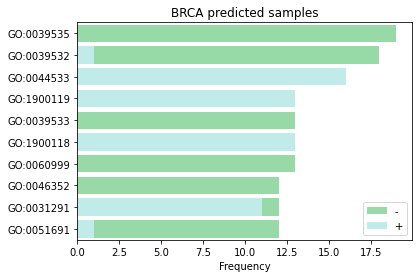

In [78]:
sns.set_color_codes("pastel")
sns.barplot(x="total", y="id_go", data=rankFreqClass,
            label="-", color="g")

sns.set_color_codes("pastel")
sns.barplot(x="+", y="id_go", data=rankFreqClass,
            label="+", color="c")
plt.legend()
plt.xlabel("Frequency")
plt.ylabel("")
plt.title("{} predicted samples".format(group))

In [79]:
#Study a cancer sample
output_idx=testset.target_names.index(group)

In [80]:
#Run to get a list of Cancer Outcomes
list_idx_samples_correct = np.where((labels==output_idx) & (pred==output_idx))[0]
list_idx_samples_correct

array([   7,    9,   10,   17,   18,   33,   35,   56,   57,   58,   77,
         84,   94,   99,  115,  116,  117,  129,  136,  145,  151,  157,
        176,  182,  183,  188,  195,  201,  203,  214,  220,  229,  248,
        284,  285,  287,  298,  308,  323,  326,  340,  341,  347,  350,
        361,  365,  375,  377,  379,  387,  405,  416,  420,  428,  431,
        433,  440,  446,  449,  458,  460,  461,  464,  470,  476,  478,
        484,  495,  526,  528,  538,  547,  555,  558,  579,  587,  589,
        597,  607,  618,  622,  627,  628,  631,  645,  648,  664,  667,
        683,  688,  700,  703,  706,  708,  723,  725,  726,  738,  740,
        749,  752,  756,  763,  767,  777,  786,  796,  810,  836,  851,
        855,  859,  873,  890,  892,  922,  930,  933,  936,  940,  951,
        952,  966,  978,  980,  985,  991,  995,  996,  999, 1000, 1001,
       1006, 1019, 1032, 1036, 1054, 1060, 1066, 1069, 1076, 1090, 1096,
       1100, 1121, 1135, 1145, 1151, 1163, 1174, 11

In [117]:
#Run to get a list of Non-Cancer Outcomes
list_idx_samples_correct = np.where((labels!=output_idx) & (pred==output_idx))[0]
list_idx_samples_correct

array([  16,   19,   37,   42,  104,  127,  160,  168,  177,  186,  187,
        222,  223,  250,  270,  274,  327,  362,  363,  389,  398,  408,
        419,  451,  481,  486,  512,  518,  521,  530,  575,  608,  616,
        660,  668,  686,  704,  719,  727,  742,  759,  764,  772,  781,
        791,  812,  849,  856,  861,  887,  891,  917,  961,  967,  981,
        993, 1013, 1018, 1029, 1048, 1098, 1127, 1138, 1168, 1181, 1206,
       1214, 1221, 1233, 1241, 1242], dtype=int64)

In [118]:
k=list_idx_samples_correct[2]

In [119]:
labels[k].item()

11

In [120]:
pred[k].item()

0

In [121]:
if DATASET=="TCGA":
    print(prob[k][output_idx].item())
else:
    prob[k].item()

0.09119049459695816


In [122]:
print("Total Relevance Score:")
if DATASET=="TCGA":
    print(output[k][output_idx].item())
else:
    output[k].item()

Total Relevance Score:
0.09528666734695435


In [123]:
mask = torch.nonzero(attribution[k].detach(),as_tuple=True)
mask

(tensor([1048, 1817, 3341, 5817, 6535, 6538, 6638, 7332, 7333, 7335, 7336]),)

In [124]:
list_go_selected = [map_int_go[idx] for idx in mask[0].numpy()]
list_go_selected

['GO:0007216',
 'GO:0019043',
 'GO:0043537',
 'GO:1901620',
 'GO:2001028',
 'GO:2001044',
 'GO:0002785',
 'GO:0060671',
 'GO:0060690',
 'GO:0060720',
 'GO:0060723']

In [125]:
saliency_map = pd.DataFrame(data=torch.stack((attribution[k][mask],activation_map_mask[k][mask],model.fc2.weight[0,mask[0]]),1).detach().numpy(),columns=["R_i","a_i","w_i"],index=list_go_selected)
saliency_map

,R_i,a_i,w_i
GO:0007216,0.009366,1.0,0.009366
GO:0019043,-0.012144,1.0,-0.012144
GO:0043537,-0.016569,1.0,-0.016569
GO:1901620,-0.016740,1.0,-0.016740
GO:2001028,0.031038,1.0,0.031038
GO:2001044,0.009630,1.0,0.009630
GO:0002785,0.024331,-1.0,-0.024331
GO:0060671,0.005224,-1.0,-0.005224
GO:0060690,-0.016042,-1.0,0.016042
GO:0060720,0.035459,-1.0,-0.035459


In [126]:
#Number of nodes with negative contribution
np.sum(saliency_map["R_i"]<0)

4

In [127]:
np.sum(saliency_map["R_i"]<0)/saliency_map.shape[0]*100

36.36363636363637

In [128]:
rank = saliency_map.sort_values(by=["R_i","a_i"],ascending=False)
rank

,R_i,a_i,w_i
GO:0060720,0.035459,-1.0,-0.035459
GO:2001028,0.031038,1.0,0.031038
GO:0002785,0.024331,-1.0,-0.024331
GO:2001044,0.009630,1.0,0.009630
GO:0060723,0.009629,-1.0,-0.009629
GO:0007216,0.009366,1.0,0.009366
GO:0060671,0.005224,-1.0,-0.005224
GO:0019043,-0.012144,1.0,-0.012144
GO:0060690,-0.016042,-1.0,0.016042
GO:0043537,-0.016569,1.0,-0.016569


In [129]:
rank["R_i"] = np.round(rank["R_i"],decimals=2)
rank

,R_i,a_i,w_i
GO:0060720,0.04,-1.0,-0.035459
GO:2001028,0.03,1.0,0.031038
GO:0002785,0.02,-1.0,-0.024331
GO:2001044,0.01,1.0,0.009630
GO:0060723,0.01,-1.0,-0.009629
GO:0007216,0.01,1.0,0.009366
GO:0060671,0.01,-1.0,-0.005224
GO:0019043,-0.01,1.0,-0.012144
GO:0060690,-0.02,-1.0,0.016042
GO:0043537,-0.02,1.0,-0.016569


In [130]:
#number of leaves
len(set(rank.index) & set(leaves))

11

In [131]:
len(set(rank.index) & set(leaves))/rank.shape[0]*100

100.0

In [132]:
for idx_go in rank.index:
    print(go[idx_go])

GO:0060720	level-03	depth-04	spongiotrophoblast cell proliferation [biological_process]
GO:2001028	level-06	depth-10	positive regulation of endothelial cell chemotaxis [biological_process]
GO:0002785	level-07	depth-08	negative regulation of antimicrobial peptide production [biological_process]
GO:2001044	level-05	depth-06	regulation of integrin-mediated signaling pathway [biological_process]
GO:0060723	level-04	depth-06	regulation of cell proliferation involved in embryonic placenta development [biological_process]
GO:0007216	level-04	depth-07	G protein-coupled glutamate receptor signaling pathway [biological_process]
GO:0060671	level-04	depth-05	epithelial cell differentiation involved in embryonic placenta development [biological_process]
GO:0019043	level-04	depth-04	establishment of viral latency [biological_process]
GO:0060690	level-05	depth-05	epithelial cell differentiation involved in salivary gland development [biological_process]
GO:0043537	level-07	depth-10	negative regulatio

In [133]:
dfTopGO = pd.DataFrame(index=rank.index)
dfTopGO['desc']=np.asarray([go[go_id].name for go_id in rank.index])
dfTopGO['relevance']= rank["R_i"]
dfTopGO['weight']= np.round(rank["w_i"],decimals=2)
dfTopGO['sign']= ["deeppink" if rank.loc[go,"R_i"]>0 else "royalblue" for go in dfTopGO.index]

In [134]:
dfTopGO

,desc,relevance,weight,sign
GO:0060720,spongiotrophoblast cell proliferation,0.04,-0.04,deeppink
GO:2001028,positive regulation of endothelial cell chemot...,0.03,0.03,deeppink
GO:0002785,negative regulation of antimicrobial peptide p...,0.02,-0.02,deeppink
GO:2001044,regulation of integrin-mediated signaling pathway,0.01,0.01,deeppink
GO:0060723,regulation of cell proliferation involved in e...,0.01,-0.01,deeppink
GO:0007216,G protein-coupled glutamate receptor signaling...,0.01,0.01,deeppink
GO:0060671,epithelial cell differentiation involved in em...,0.01,-0.01,deeppink
GO:0019043,establishment of viral latency,-0.01,-0.01,royalblue
GO:0060690,epithelial cell differentiation involved in sa...,-0.02,0.02,royalblue
GO:0043537,negative regulation of blood vessel endothelia...,-0.02,-0.02,royalblue


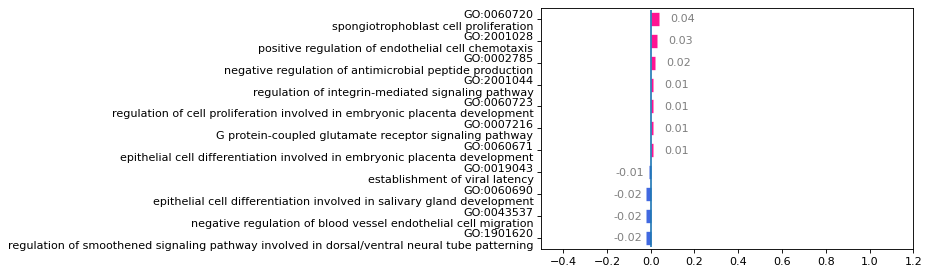

In [135]:
import matplotlib.patches as mpatches

plt.figure(figsize=(6,4), dpi= 80)
for idx_go in dfTopGO.index:
    if dfTopGO.loc[idx_go,"relevance"]>0:
        plt.hlines(y=dfTopGO.loc[idx_go,"desc"], xmin=0, xmax=dfTopGO.loc[idx_go,"relevance"], colors=dfTopGO.loc[idx_go,"sign"],linewidth=12)
    else:
        plt.hlines(y=dfTopGO.loc[idx_go,"desc"], xmin=dfTopGO.loc[idx_go,"relevance"], xmax=0, colors=dfTopGO.loc[idx_go,"sign"],linewidth=12)
plt.vlines(x=0,ymin=10.4, ymax=-0.4)

for x, y in zip(dfTopGO.relevance, dfTopGO.desc):
    if x<0:
        t = plt.text(x-0.15 ,y, "{}".format(round(x, 2)),verticalalignment='center', color="C7")
    else:
        t = plt.text(x+0.05, y, "{}".format(round(x, 2)), verticalalignment='center',color="C7")

loc,_=plt.yticks()
plt.yticks(loc,
           ["{}\n{}".format(i,j) for i,j in zip(dfTopGO.index,dfTopGO.desc)])
plt.margins(0.01)
plt.xlim(left=-0.5,right=1.2)
plt.gca().invert_yaxis()